In [5]:
import os
import sys
import warnings
from datetime import datetime
from functools import partial

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import febrisk
lib_path = os.path.join(os.path.abspath('.'), '..\\..')
sys.path.append(lib_path)
from febrisk.option import bsm, implied_vol
from febrisk.risk import VaR, expected_shortfall

warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

# Problem 1
Assume you have a call and a put option with the following
- Current Stock Price $165  
- Current Date 02/25/2022  
- Options Expiration Date 03/18/2022 
- Risk Free Rate of 0.25%  
- Continuously Compounding Coupon of 0.53%  

Calculate the time to maturity using calendar days (not trading days).  
For a range of implied volatilities between 10% and 80%, plot the value of the call and the put.  
Discuss these graphs. How does the supply and demand affect the implied volatility?  

## Solution 1
As we can see from the graph, the more volatile the underlying asset becomes, the more valuable the options are.  
The rise in demand or decrease in supply for an option will cause its price to rise. Given all other conditions equal (e.g., the price of the underlying asset), this means the implied volatility must rise, as it moves in the same direction with option value.
For the same reason, rise in supply or decrease in demand will result in a lowered implied volatility. 

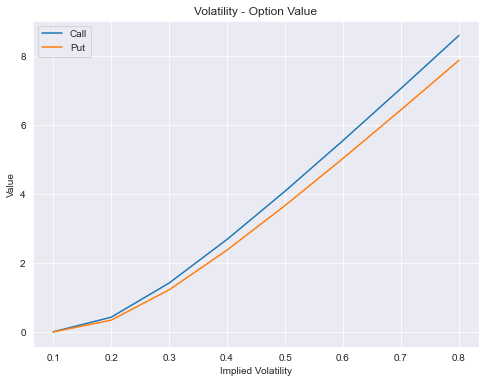

In [6]:
p = 165
t = (datetime(2022, 3, 18) - datetime(2022, 2, 25)).days / 365
r = 0.0025 
q = 0.0035 

# calculate the value of slightly out-of-the-money options
sigmas = np.linspace(0.1, 0.8, 8)
call_values = np.array([bsm(is_call=True, price=p, strike=p+10, ttm=t, r_f=r, div_rate=q, ivol=s) for s in sigmas]) 
put_values = np.array([bsm(is_call=False, price=p, strike=p-10, ttm=t, r_f=r, div_rate=q, ivol=s) for s in sigmas])

# plot Volatility - Option Value
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(sigmas, call_values, ax=ax, label='Call')
sns.lineplot(sigmas, put_values, ax=ax, label='Put')
ax.set_title("Volatility - Option Value")
ax.set_xlabel("Implied Volatility")
ax.set_ylabel("Value")
ax.legend()

# Problem 2
Use the options found in AAPL_Options.csv
- Current AAPL price is 164.85
- Current Date, Risk Free Rate and Dividend Rate are the same as problem #1.

Calculate the implied volatility for each option.
Plot the implied volatility vs the strike price for Puts and Calls. Discuss the shape of these graphs. What market dynamics could make these graphs?

There are bonus points available on this question based on your discussion. Take some time to research if needed.

## Solution 2
Firstly, we calculate the implied volatility and plot them against the strike prices. We can find that the dots form an upward curve, which is known as a "volatility smile".

Text(0.5, 1.0, 'Strike Price - Implied Volatility')

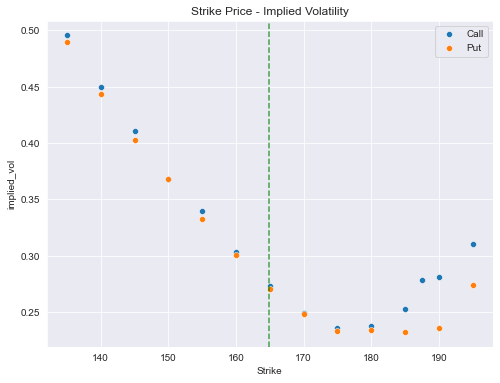

In [7]:
# calculate implied volatility
options = pd.read_csv("AAPL_Options.csv", parse_dates=['Expiration'])
options['IsCall'] = (options['Type'] == 'Call')
options['ttm'] = options['Expiration'].apply(lambda x: (x - datetime(2022, 2, 25)).days / 365)
options['implied_vol'] = options.apply(
    lambda df: implied_vol(df['IsCall'], 164.85, df['Strike'], df['ttm'], 0.0025, 0.0035, df['Last Price']), 
    axis=1
)

# plot strike - implied volatility
fig, ax = plt.subplots(figsize=(8, 6))
for type_, df in options.groupby('Type'):
    sns.scatterplot(df['Strike'], df['implied_vol'], ax=ax, label=type_)

ax.axvline(164.85, 0, 1, linestyle='--', alpha=0.7, color="green")
ax.set_title('Strike Price - Implied Volatility')

One major causation of volatility smile is that the stock prices are usually not log-normally distributed as the BSM model assumes. They tend to have fat tails. We can plot the real distribution of Apple prices and compare it to a log normal distribution. We will see that the real distribution has two peaks, and stock prices are less concentrated around 164.85.   
The real distribution suggests that stock price will be more likely to deviate from its current value, as the current value has a relatively low probability density. With such an expectation, the investors will prefer deeply in-the-money or out-of-the-money options. The high demand for these options caused their price to rise, and the BSM model to give higher results when calculating the implied volatilities.  
There are also other reasons for people to buy more options with high or low strike prices. For example, the Prospect Theory points out that people tend to overestimate the probability for extreme situations to occur. This can also result in volatility smiles.

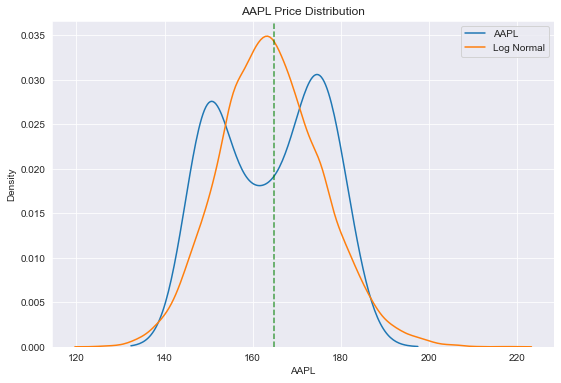

In [8]:
all_prices = pd.read_csv("DailyPrices.csv")
aapl_prices = all_prices['AAPL']

# plot the distribution of a log normal variable that has the same mean and std
log_aapl_prices = np.log(aapl_prices)
u = np.mean(log_aapl_prices)
sigma = np.std(log_aapl_prices)
log_normal_prices = scipy.stats.norm(u, sigma).rvs(10000)

# compare the log normal distribution to 
fig, ax = plt.subplots(figsize=(9, 6))
sns.kdeplot(aapl_prices, label='AAPL')
sns.kdeplot(np.e**log_normal_prices, label='Log Normal')
ax.axvline(164.85, 0, 1, linestyle='--', alpha=0.7, color="green")
ax.set_title('AAPL Price Distribution')
ax.legend()

# Problem 3  
Use the portfolios found in problem3.csv
- Current AAPL price is 164.85
- Current Date, Risk Free Rate and Dividend Rate are the same as problem #1.    

For each of the portfolios, graph the portfolio value over a range of underlying values. Plot the portfolio
values and discuss the shapes. Bonus points available for tying these graphs to other topics discussed in
the lecture.  

Using DailyReturn.csv. Fit a Normal distribution to AAPL returns – assume 0 mean return. Simulate
AAPL returns 10 days ahead and apply those returns to the current AAPL price (above). Calculate Mean,
VaR and ES. Discuss.  

Hints:  
- you will need to calculate the implied volatility – not the same value as in #2
- you need to take into account the change in dates for option valuations. You are simulating
forward in time and options valuations are a function of time
- Calculate the PL from the current portfolio value using Current Date

## Solution 3

In [9]:
portfolios = pd.read_csv("problem3.csv", parse_dates=['ExpirationDate'])
portfolios['CurrentValue'] = portfolios['CurrentPrice'] * portfolios['Holding']

# calculate implied volatilities of options
options = portfolios.loc[portfolios.Type == 'Option', :]
options['IsCall'] = options['OptionType'] == 'Call'
options['ttm'] = options.apply(lambda x: ((x['ExpirationDate'] - datetime(2022, 2, 25)).days / 365), axis=1)
options['ImpliedVol'] = options.apply(
    lambda df: implied_vol(df['IsCall'], 164.85, df['Strike'], df['ttm'], 
                           0.0025, 0.0035, df['CurrentPrice']), 
    axis=1
)

# v_func is a function that accepts the underlying price and returns the value of the asset based on other parameters in the table
# after other parameters are updated, the v_func should be updated as well 
def cal_opt_value_func(df):
    f = partial(bsm, is_call=df['IsCall'], strike=df['Strike'], ttm=df['ttm'], 
                r_f=0.0025, div_rate=0.0035, ivol=df['ImpliedVol'])
    h = df['Holding']
    return lambda x: f(price=x) * h    
options['v_funcs'] = options.apply(cal_opt_value_func, axis=1)

stocks = portfolios.loc[portfolios.Type == 'Stock', :]
def cal_stk_value_func(df):
    h = df['Holding']
    return lambda x: x * h
stocks['v_funcs'] = stocks.apply(cal_stk_value_func, axis=1)

portfolios = pd.concat([options, stocks], axis=0)

In [10]:
def pfl_sim_values(portfolios: pd.DataFrame, sim_prices):
    """Use v_funcs portfolios to compute the asset values corresponding to simulated prices."""
    sim_values = pd.DataFrame(index=portfolios.index, 
                              columns=list(range(sim_prices.shape[0])))
    for i in portfolios.index:
        sim_values.loc[i, :] = np.apply_along_axis(portfolios.loc[i, :]['v_funcs'], 
                                                   axis=0, 
                                                   arr=sim_prices)
    sim_values['Portfolio'] = portfolios['Portfolio']
    return sim_values.groupby('Portfolio').sum()

### 3.1 portfolio values given different stock prices 

- Straddle: Holds 1 Call and 1 Put. It will make money when the price moves in either direction.  
- SynLong: Holds 1 Call and shorts 1 Put. It will make more money when the price goes up, and lose more when it goes down.
- Call Spread: Holds 1 Call and shorts 1 Call with higher strike. It will make money when the price goes up, and lose money when price falls, but there is a limit.
- Put Spread: Holds 1 Put and shorts 1 Put with lower strike. It's behavior is opposite to Call Spread.
- Stock, Call, Put: Behave just like stocks and options when the price moves.
- Covered Call: Holds 1 stock and shorts 1 Call. The shape on the graph is like shorting 1 Put.
- Protected Put: Holds 1 stock and 1 Put. The shape on the graph is like holding 1 Call.

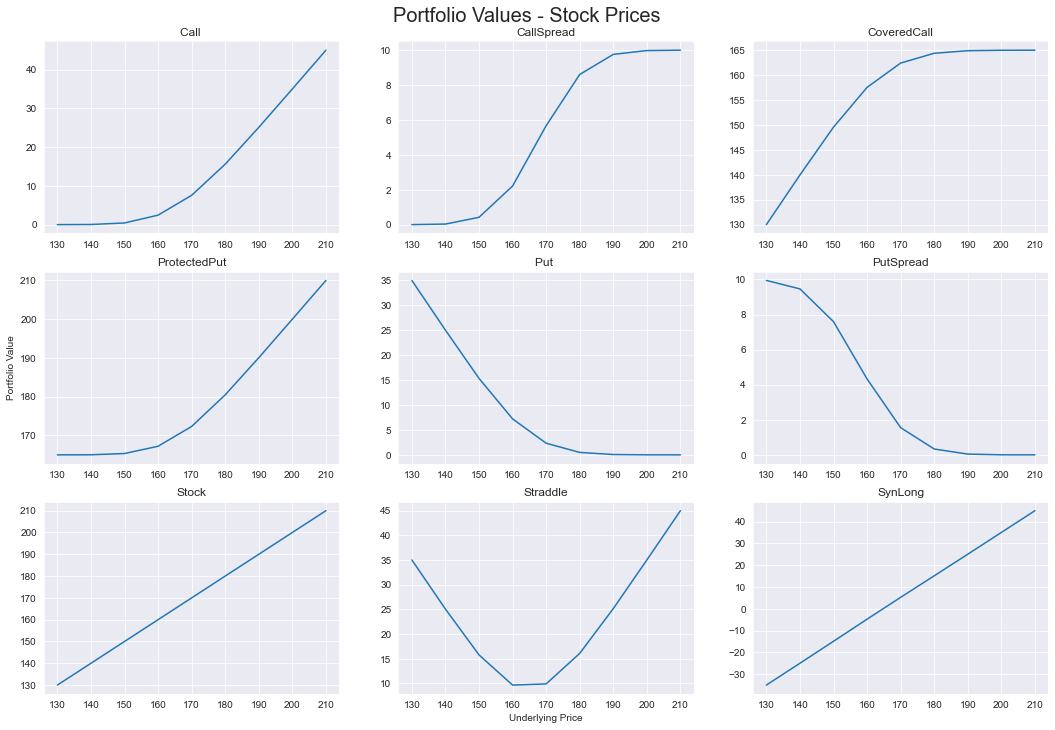

In [11]:
sim_prices = np.linspace(130, 210, 9)
sim_values = pfl_sim_values(portfolios, sim_prices)

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("Portfolio Values - Stock Prices ", fontsize=20, y=0.92)
idx = 0
for pfl, df in sim_values.groupby('Portfolio'):
    i, j = idx // 3, idx % 3
    ax = axes[i][j]
    sns.lineplot(x=sim_prices, y=df.iloc[0, :].values, ax=ax)
    ax.set_title(pfl)
    if i == 2 and j == 1:
        ax.set_xlabel('Underlying Price')
    if i == 1 and j == 0:
        ax.set_ylabel('Portfolio Value')
    idx += 1

### 3.2 portfolio return in 10 days
The following table and graphs show the distribution of portfolio returns 10 days later. The ES and mean are annotated by the red and green dashed line.  
Discoveries:
- Most portfolios have average return close to 0, except SynLong. As the effect of price change on portfolio value is greatly enlarged, it is very risky and has extremely high VaR and ES.
- Covered Call & Protected Put: Though they're like shorting a call or holding a put, their risks are much smaller at the cost of profitability.
- Call Spread & Put Spread: Their VaR and ES are close to those of Call and Put, but they are not so profitable as holding options.
- Straddle: Seems to have moderate risk, but still riskier than just holding stocks.

In [13]:
all_rets = pd.read_csv("DailyReturn.csv")
std = all_rets['AAPL'].std()
nsamples = 50000
sim_rets = scipy.stats.norm(0, std).rvs((10, nsamples))
sim_prices = 164.85 * (1 + sim_rets).prod(axis=0)  # possible prices 10 days

# update ttm and v_funcs
options = portfolios.loc[portfolios.Type == 'Option', :]
options['ttm'] = options.apply(lambda x: ((x['ExpirationDate'] - datetime(2022, 2, 25)).days - 10) / 365, axis=1)
options['v_funcs'] = options.apply(cal_opt_value_func, axis=1)
portfolios.loc[portfolios.Type == 'Option', :] = options

curr_values = portfolios.groupby('Portfolio')['CurrentValue'].sum()
sim_values = pfl_sim_values(portfolios, sim_prices)
sim_rets = (sim_values.T / curr_values - 1).T
sim_value_chgs = (sim_values.T - curr_values).T

In [16]:
risk_metrics = pd.DataFrame(index=sim_value_chgs.index)
risk_metrics['mean'] = sim_value_chgs.mean(axis=1)
risk_metrics['VaR'] = sim_value_chgs.apply(lambda x:VaR(x, 0), axis=1)
risk_metrics['ES'] = sim_value_chgs.apply(lambda x:expected_shortfall(x), axis=1)
risk_metrics

,mean,VaR,ES
Portfolio,,,
Call,0.114595,4.358820,4.435184
CallSpread,-0.241876,3.639153,3.715283
CoveredCall,-0.150163,9.128753,12.182153
ProtectedPut,0.239424,4.143372,4.201838
Put,0.274991,4.254978,4.334247
PutSpread,0.396478,2.674248,2.742863
Stock,-0.035568,13.487573,16.617337
Straddle,0.389586,2.443232,2.452474
SynLong,-0.160396,13.703021,16.850682


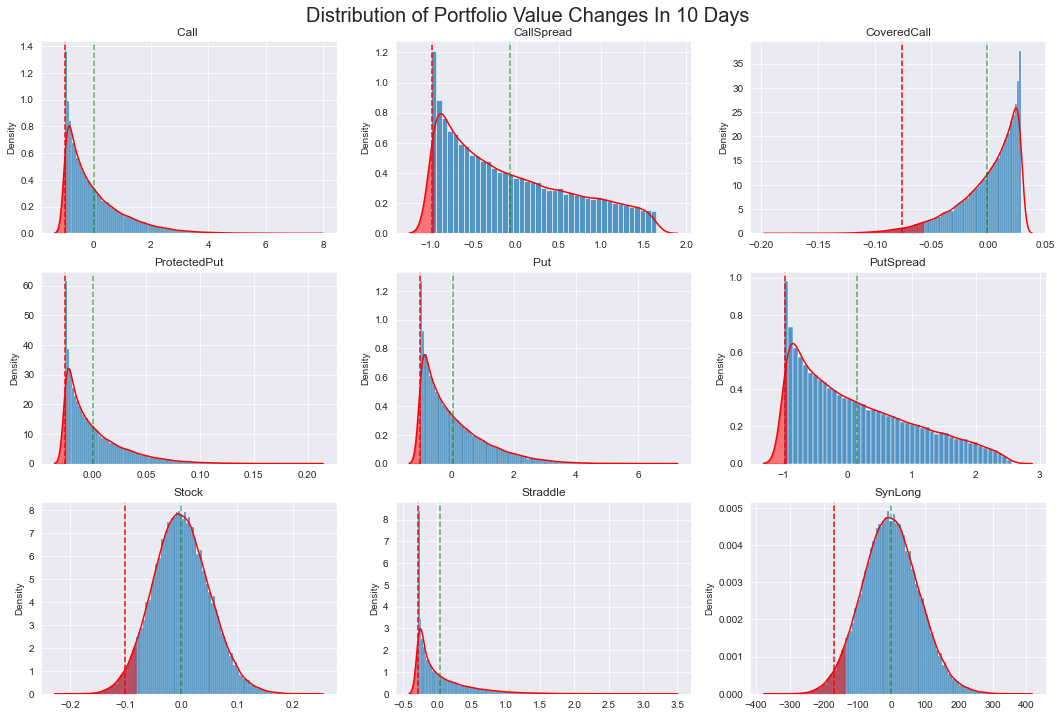

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("Distribution of Portfolio Value Changes In 10 Days", fontsize=20, y=0.92)

idx = 0
for pfl, df in sim_rets.groupby('Portfolio'):
    i, j = idx // 3, idx % 3
    ax = axes[i][j]
    chgs = df.iloc[0, :].values
    sns.kdeplot(chgs, ax=ax, color='r')
    sns.histplot(chgs, ax=ax, stat='density')

    mean = risk_metrics.loc[pfl, 'mean']
    var = risk_metrics.loc[pfl, 'VaR']
    es = risk_metrics.loc[pfl, 'ES']

    ret, ret_density = ax.lines[0].get_data()
    ax.fill_between(ret, ret_density, where=(ret<-var), color='r', alpha=0.5)
    ax.axvline(-es, 0, 1, color='r', linestyle='--')
    ax.axvline(mean, 0, 1, color='green', linestyle='--', alpha=0.6)
    ax.set_title(pfl)

    idx += 1